In [2]:
'''
code by Runqiu Bao, bao@robot.t.u-tokyo.ac.jp
'''

def downscale(I, D, K, lvl):#验证通过
    if lvl<=1:
        Id = I
        Dd = D
        Kd = K
        return Id, Dd, Kd
    # intrinsics
    Kd=0.5*K
    Kd[:,2]-=0.25
    Kd[2,2]=1
    # intensity image
    height,width=I.shape
    Id=cv2.GaussianBlur(I, ksize=(5,5), sigmaX=2)
    Id=cv2.resize(I,(int(width/2),int(height/2)),interpolation=cv2.INTER_LINEAR)
#     Id=cv2.resize(I,(int(width/2),int(height/2)),interpolation=cv2.INTER_CUBIC)
    # depth image
    DdCountValid=np.sign(D[0:height:2, 0:width:2])+np.sign(D[1:height:2, 0:width:2])+np.sign(D[0:height:2, 1:width:2])+np.sign(D[1:height:2, 1:width:2])
    Dd=np.divide(D[0:height:2, 0:width:2]+D[0:height:2, 1:width:2]+D[1:height:2, 0:width:2]+D[1:height:2, 1:width:2], DdCountValid)
    Dd = np.where(np.isnan(Dd), 0, Dd)
#     set_trace()
    return downscale(Id,Dd,Kd,lvl-1)

def se3Exp(twist):#验证通过
    M = np.array([
        [0, -twist[5], twist[4], twist[0]],
        [twist[5], 0, -twist[3], twist[1]],
        [-twist[4], twist[3], 0, twist[2]],
        [0, 0, 0, 0]
    ]).astype(np.double)
#     print("M matrix: {}".format(M))
    T = expm(M)
    return T

def calcErr(IRef, DRef, I, xi, K):
    # calculate residuals
    T = se3Exp(xi)
    R = T[0:3, 0:3]
    t = T[0:3, 3]
    
    RKInv = np.matmul(R,np.linalg.inv(K))
    nImg = np.zeros(IRef.shape[0:2])-10
    mImg = np.zeros(IRef.shape[0:2])-10
    
    for n in range(0,IRef.shape[1]):#x
        for m in range(0,IRef.shape[0]):#y
            p = np.array([
                [n],
                [m],
                [1]
            ]).astype(np.double)*DRef[m,n]
            pTrans = np.dot(K,(np.dot(RKInv,p)+t[:,np.newaxis])) #pTrans是IRef中pixel经过变换后在I图像中的pixel的坐标
#             set_trace()
            pTrans = pTrans.astype(np.double)
            if pTrans[2]>0 and DRef[m,n]>0:
                nImg[m,n]=pTrans[0]/pTrans[2]
                mImg[m,n]=pTrans[1]/pTrans[2]
#     set_trace()
    mapped_img = cv2.remap(I, nImg.astype(np.float32), mImg.astype(np.float32), cv2.INTER_LINEAR)# INTER_LINEAR
    err = mapped_img-IRef
#     err = abs(err)
    err = err.flatten('F')
    return err

def se3Log(T):
    lg = logm(T)
    twist = np.array([
        [lg[0,3]],
        [lg[1,3]],
        [lg[2,3]],
        [lg[2,1]],
        [lg[0,2]],
        [lg[1,0]]
    ]).astype(np.double)
    return twist

def deriveAnalytic(IRef, DRef, I, xi, K):
    # calculate analytic derivative
    ## get shorthands
    T = se3Exp(xi)
    R = T[0:3, 0:3]
    t = T[0:3, 3]
    RKInv = np.matmul(R,np.linalg.inv(K))
    
    nImg = np.zeros(IRef.shape[0:2])-10
    mImg = np.zeros(IRef.shape[0:2])-10
    # these contain the 3d position of the transformed point
    xp=np.zeros(IRef.shape[0:2])
    yp=np.zeros(IRef.shape[0:2])
    zp=np.zeros(IRef.shape[0:2])
    xp[:]=np.nan
    yp[:]=np.nan
    zp[:]=np.nan
    for n in range(0,IRef.shape[1]):#x
        for m in range(0,IRef.shape[0]):#yxi=np.array([-0.0021, 0.0057, 0.0374, -0.0292, -0.0183, -0.0009])
            p = np.array([
                [n],
                [m],
                [1]
            ])*DRef[m,n]
            pTrans = np.matmul(RKInv,p)+t[:,np.newaxis] #pTrans是IRef中pixel经过变换后在I坐标系中的3d坐标
            pTrans = pTrans.astype(np.float32)
            # if point is valid, project and save result
            if pTrans[2]>0 and DRef[m,n]>0:
                pTransProj = np.matmul(K,pTrans)
                nImg[m,n]=pTransProj[0,:]/pTransProj[2,:]
                mImg[m,n]=pTransProj[1,:]/pTransProj[2,:]
                # warped 3d point, for calculation of Jacobian
                xp[m,n]=pTrans[0,0]
                yp[m,n]=pTrans[1,0]
                zp[m,n]=pTrans[2,0]
    # calculate analytic derivative
    height, width = I.shape[0:2]
    ## 1. calculate image derivatives and interpolate at warped position
    dxI = np.zeros(I.shape[0:2])
    dyI = np.zeros(I.shape[0:2])
    dxI[:] = np.nan
    dyI[:] = np.nan
    dyI[1:-1,:]=0.5*(I[2:,:]-I[0:-2,:])
    dxI[:,1:-1]=0.5*(I[:,2:]-I[:,0:-2])
    Ixfx=K[0,0]*cv2.remap(dxI, nImg.astype(np.float32), mImg.astype(np.float32), cv2.INTER_LINEAR)# INTER_LINEAR
    Ixfx=Ixfx.flatten('F')
    Iyfy=K[1,1]*cv2.remap(dyI, nImg.astype(np.float32), mImg.astype(np.float32), cv2.INTER_LINEAR)# INTER_LINEAR
    Iyfy=Iyfy.flatten('F')
    ## 2. get warped 3d points (x',y',z')
    xp=xp.flatten('F')
    yp=yp.flatten('F')
    zp=zp.flatten('F')
    ## 3. implement gradient
    Jac = np.zeros((height*width, 6))
    Jac[:,0] = Ixfx/zp
    Jac[:,1] = Iyfy/zp
    Jac[:,2] = -(Ixfx*xp+Iyfy*yp)/(zp*zp)
    Jac[:,3] = -(Ixfx*xp*yp)/(zp*zp)-Iyfy*(1+np.square(yp/zp))
    Jac[:,4] = Ixfx*(1+np.square(xp/zp))+Iyfy*xp*yp/(zp*zp)
    Jac[:,5] = (-Ixfx*yp+Iyfy*xp)/zp
    ## 4. residual image
    mapped_img = cv2.remap(I, nImg.astype(np.float32), mImg.astype(np.float32), cv2.INTER_LINEAR)# INTER_LINEAR
    residual = mapped_img-IRef
    residual = residual.flatten('F')
    return Jac, residual

## 1. image warping

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import scipy
from IPython.core.debugger import set_trace
from scipy.linalg import expm, logm
import os

def main():
    dataset = 1 #1=fr1/xyz, 2=fr3/long-office-household
    
    if dataset==1:
        # intrinsics
        K=np.array([
            [517.3, 0, 318.6],
            [0, 516.5, 255.3],
            [0,0,1]
        ]).astype(np.double)
        # first pair of input frames
        c1=cv2.imread('rgb/IRef0.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)
        c2=cv2.imread('rgb/I0.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)
        c1/=255
        c2/=255
        d1=cv2.imread('depth/DRef0.png', cv2.IMREAD_UNCHANGED).astype(np.float32)
        d2=cv2.imread('depth/D0.png', cv2.IMREAD_UNCHANGED).astype(np.float32)
        d1=d1/5000
        d2=d2/5000
    else:
        # intrinsics
        K=np.array([
            [535.4, 0, 320.1],
            [0, 539.2, 247.6],
            [0,0,1]
        ]).astype(np.double)
        # second pair of input frames
        c1=cv2.imread('rgb/IRef1.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)
        c2=cv2.imread('rgb/I1.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)
        d1=cv2.imread('depth/DRef1.png', cv2.IMREAD_UNCHANGED).astype(np.float32)
        d2=cv2.imread('depth/D1.png', cv2.IMREAD_UNCHANGED).astype(np.float32)
        d1=d1/5000
        d2=d2/5000
    
    # initialization
    xi=np.array([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3]).astype(np.float32)
    xi=np.array([-0.0021, 0.0057, 0.0374, -0.0292, -0.0183, -0.0009]).astype(np.float32)
#     xi=np.array([-0.0023, 0.006, 0.0374, -0.0290, -0.0182, -0.0009])
    
    # pyramid levels
#     epss = {5:1e-3, 4:5e-4, 3:1e-4, 2:9e-5, 1:5e-5} 
    for lvl in range(5,0,-1):
        print(lvl,':')
        
        # downscale reference frame (intensity image, depth image and K matrix)
        IRef, DRef, Klvl = downscale(c1, d1, K, lvl)
        # downscale target frame (intensity image and depth map)
        I, D, _ = downscale(c2, d2, K, lvl)
        
        # iterate at most 20 steps
        errLast=1e10
        for i in range(1,21):
#             plt.subplot(1,2,1)
            # calculate Jacobian of residual function (Matrix of dim (width*height)x6)
#             Jac, residual=deriveNumeric(IRef, DRef, I, xi, Klvl)
            Jac, residual=deriveAnalytic(IRef, DRef, I, xi, Klvl)
            notValid = np.where(np.isnan(np.sum(Jac,1)))[0]
            Jac[notValid,:] = 0
            residual[notValid]=0
#             set_trace()
#             # gauss-newton
#             upd = -np.matmul(np.linalg.inv(np.matmul(Jac.transpose(), Jac)), np.matmul(Jac.transpose(), residual))
            # LM
            # LM
            lam = 0.1
            H = np.matmul(Jac.transpose(), Jac)
            upd = -np.matmul(np.matmul(np.linalg.inv(H+lam*np.diag(np.diag(H))),Jac.transpose()),residual)

            # multiply increment from left onto the current estimate
            lastXi = xi
            xi = se3Log(np.matmul(se3Exp(upd), se3Exp(xi)))
            
            # get mean and display
            err=(residual*residual).mean()
            
            # early break
            if (err/errLast)>0.9995:
                break
                
            errLast=err
            print("level {} iteration {} finished!".format(lvl, i))
        print("level {} finished!".format(lvl))
    print("xi: {}".format(xi))
    return xi, c1,c2,d1,d2,K

In [50]:
def calcErr_visual(IRef, DRef, I, xi, K):
    # calculate residuals
    T = se3Exp(xi)
    R = T[0:3, 0:3]
    t = T[0:3, 3]
#     t[0]=0
    
    RKInv = np.matmul(R,np.linalg.inv(K))
    nImg = np.zeros(IRef.shape[0:2])-10
    mImg = np.zeros(IRef.shape[0:2])-10
    
    for n in range(0,IRef.shape[1]):#x
        for m in range(0,IRef.shape[0]):#y
            p = np.array([
                [n],
                [m],
                [1]
            ]).astype(np.double)*DRef[m,n]
            pTrans = np.dot(K,(np.dot(RKInv,p)+t[:,np.newaxis])) #pTrans是IRef中pixel经过变换后在I图像中的pixel的坐标
#             set_trace()
            if pTrans[2]>0 and DRef[m,n]>0:
                nImg[m,n]=pTrans[0]/pTrans[2]
                mImg[m,n]=pTrans[1]/pTrans[2]
#     set_trace()
    mapped_img = cv2.remap(I, nImg.astype(np.float32), mImg.astype(np.float32), cv2.INTER_LINEAR)
    err = mapped_img-IRef
#     err = abs(err)
#     err = err.flatten('F')
    return err, mapped_img

5 :
level 5 iteration 1 finished!
level 5 finished!
4 :


/home/runqiu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/runqiu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


level 4 iteration 1 finished!
level 4 iteration 2 finished!
level 4 finished!
3 :
level 3 iteration 1 finished!
level 3 finished!
2 :
level 2 iteration 1 finished!
level 2 finished!
1 :
level 1 iteration 1 finished!
level 1 finished!
xi: [[-0.00228202]
 [ 0.00537577]
 [ 0.03724349]
 [-0.0294601 ]
 [-0.01811891]
 [-0.00092939]]


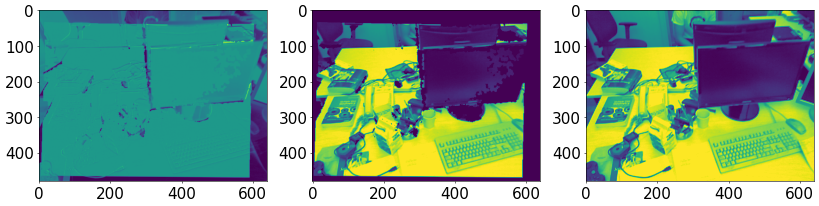

In [52]:
xi, c1, c2, d1, d2, K = main()
err, mapped_im = calcErr_visual(c1, d1, c2, xi, K)
plt.figure(figsize=(20,20), dpi=50)
plt.subplot(131)
plt.imshow(err)
plt.subplot(132)
plt.imshow(mapped_im)
plt.subplot(133)
plt.imshow(c1)

## 2. experiment first

In [ ]:
class mydata(object):
    def __init__(self, times, meanresiduals, xis):
        self.times = times
        self.meanresiduals = meanresiduals
        self.xis = xis
        
def rmse(residuals):
    return np.sqrt(((residuals) ** 2).mean())

def main(whichdataset, algo):
    #1=fr1/xyz, 2=fr3/long-office-household
    print('whichdataset:',whichdataset, 'which algo:', algo)
    # intrinsics
    K=np.array([
        [517.3, 0, 318.6],
        [0, 516.5, 255.3],
        [0,0,1]
    ]).astype(np.double)
    
    if whichdataset==1:
        gyre = 'close'
    elif whichdataset==2:
        gyre = 'middle'
    elif whichdataset==3:
        gyre = 'far'
    rgbpath = '/home/runqiu/lectures/dc1/numeric-analysis/NAreport3_RunqiuBao_37207318/rgbd_dataset_freiburg1_xyz/'+gyre+'/rgb/'
    depthpath = '/home/runqiu/lectures/dc1/numeric-analysis/NAreport3_RunqiuBao_37207318/rgbd_dataset_freiburg1_xyz/'+gyre+'/depth/'
    datasetroot = '/home/runqiu/lectures/dc1/numeric-analysis/NAreport3_RunqiuBao_37207318/rgbd_dataset_freiburg1_xyz/'+gyre+'/'
    times=[]
    meanresiduals=[]
    xis=[]
    for myindex in range(10):
        starttime = time.time()
        print('myindex:',myindex)
        c1 = cv2.imread(os.path.join(rgbpath,'IRef'+str(myindex)+'.png'), cv2.IMREAD_GRAYSCALE).astype(np.float32)
        c2 = cv2.imread(os.path.join(rgbpath,'I'+str(myindex)+'.png'), cv2.IMREAD_GRAYSCALE).astype(np.float32)
        c1/=255
        c2/=255
        d1=cv2.imread(os.path.join(depthpath,'DRef'+str(myindex)+'.png'), cv2.IMREAD_UNCHANGED).astype(np.float32)
        d2=cv2.imread(os.path.join(depthpath,'D'+str(myindex)+'.png'), cv2.IMREAD_UNCHANGED).astype(np.float32)
        d1/=5000
        d2/=5000
        
        # initialization
        xi=np.array([0, 0, 0, 0, 0, 0]).astype(np.float32)

        for lvl in range(5,0,-1):
            # downscale reference frame (intensity image, depth image and K matrix)
            IRef, DRef, Klvl = downscale(c1, d1, K, lvl)
            # downscale target frame (intensity image and depth map)
            I, D, _ = downscale(c2, d2, K, lvl)

            # iterate at most 20 steps
            errLast=1e10
            for i in range(1,21):
    #             plt.subplot(1,2,1)
                # calculate Jacobian of residual function (Matrix of dim (width*height)x6)
    #             Jac, residual=deriveNumeric(IRef, DRef, I, xi, Klvl)
                Jac, residual=deriveAnalytic(IRef, DRef, I, xi, Klvl)
                notValid = np.where(np.isnan(np.sum(Jac,1)))[0]
                Jac[notValid,:] = 0
                residual[notValid]=0
    #             set_trace()
                if algo == 1:
                    # gradient descent
                    upd = -np.matmul(Jac.transpose(), residual)
                    upd = 0.001*upd/np.linalg.norm(upd)
                elif algo == 2:
                    # gauss-newton
                    upd = -np.matmul(np.linalg.inv(np.matmul(Jac.transpose(), Jac)), np.matmul(Jac.transpose(), residual))
                elif algo == 3:
                    # LM
                    lam = 0.1
                    H = np.matmul(Jac.transpose(), Jac)
                    upd = -np.matmul(np.matmul(np.linalg.inv(H+lam*np.diag(np.diag(H))),Jac.transpose()),residual)
                else:
                    print("no such algo!")

                # multiply increment from left onto the current estimate
                lastXi = xi
                xi = se3Log(np.matmul(se3Exp(upd), se3Exp(xi)))

                # get mean and display
                err=(residual*residual).mean()

                # early break
                if (err/errLast)>0.99995:
                    break

                errLast=err
                meanresiduals.append(rmse(residual))
                xis.append(xi)
                print('dataset_'+str(myindex)+'_algo_'+str(algo)+'_one iter!')
        times.append(time.time()-starttime)
        a = mydata(times, meanresiduals, xis)
        with open(datasetroot+'dataset_'+str(myindex)+'_algo_'+str(algo)+'.pkl', 'wb') as output:
            pickle.dump(a, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
main(1,1)
main(1,2)
main(1,3)

In [ ]:
## load results from .npy
datasetroot = '/home/runqiu/lectures/dc1/numeric-analysis/NAreport3_RunqiuBao_37207318/rgbd_dataset_freiburg1_xyz/middle/'
data = {}
for i in range(7,8):
    class mydata(object):
        def __init__(self, times, meanresiduals, xis):
            self.times = times
            self.meanresiduals = meanresiduals
            self.xis = xis
    with open(datasetroot+'dataset_'+str(i)+'_algo_3.pkl', 'rb') as input:
        mydata = pickle.load(input)
        data[i]=(mydata.meanresiduals)

In [ ]:
# draw figures
import matplotlib.pyplot as plt  
x=np.arange(1,101,1)
y=[]
colors = {0:'b',1:'g',2:'r',3:'darkkhaki',4:'m',5:'y',6:'cornflowerblue',7:'seagreen', 8:'bisque', 9:'slategrey'}
ls={}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
plt.rc('font', **font)
plt.figure(figsize=(20,10), dpi=100)
for i in range(10):
    y=data[9][0+100*i:100+100*i]
    ls[i]=plt.plot(x,y,color=colors[i], linestyle='dashed',label='img'+str(i))
# plt.plot(x1,y1,'ro-',x2,y2,'go-',x3,y3,'bo-')
plt.title('Image warping RMSE residuals \n(10 image pairs, 5 pyramid levels, 20 iterations each)')
plt.xlabel('Iterations')
plt.ylabel('Residuals (RMSE)')
plt.legend()
# plt.show()
plt.savefig('test.png')

## 3. second experiment

In [41]:
class mydata(object):
    def __init__(self, times, meanresiduals, xis):
        self.times = times
        self.meanresiduals = meanresiduals
        self.xis = xis
        
def rmse(residuals):
    return np.sqrt(((residuals) ** 2).mean())

def main2(whichdataset, algo, gts):
    #1=fr1/xyz, 2=fr3/long-office-household
    print('whichdataset:',whichdataset, 'which algo:', algo)
    # intrinsics
    K=np.array([
        [517.3, 0, 318.6],
        [0, 516.5, 255.3],
        [0,0,1]
    ]).astype(np.double)
    
    if whichdataset==1:
        gyre = 'close'
    elif whichdataset==2:
        gyre = 'middle'
    elif whichdataset==3:
        gyre = 'far'
    rgbpath = '/home/runqiu/lectures/dc1/numeric-analysis/NAreport3_RunqiuBao_37207318/rgbd_dataset_freiburg1_xyz/'+gyre+'/rgb/'
    depthpath = '/home/runqiu/lectures/dc1/numeric-analysis/NAreport3_RunqiuBao_37207318/rgbd_dataset_freiburg1_xyz/'+gyre+'/depth/'
    datasetroot = '/home/runqiu/lectures/dc1/numeric-analysis/NAreport3_RunqiuBao_37207318/rgbd_dataset_freiburg1_xyz/'+gyre+'/'
    times=[]
    meanresiduals=[]
    xis=[]
    
    for myindex in range(7,8):
        starttime = time.time()
        print('myindex:',myindex)
        c1 = cv2.imread(os.path.join(rgbpath,'IRef'+str(myindex)+'.png'), cv2.IMREAD_GRAYSCALE).astype(np.float32)
        c2 = cv2.imread(os.path.join(rgbpath,'I'+str(myindex)+'.png'), cv2.IMREAD_GRAYSCALE).astype(np.float32)
        c1/=255
        c2/=255
        d1=cv2.imread(os.path.join(depthpath,'DRef'+str(myindex)+'.png'), cv2.IMREAD_UNCHANGED).astype(np.float32)
        d2=cv2.imread(os.path.join(depthpath,'D'+str(myindex)+'.png'), cv2.IMREAD_UNCHANGED).astype(np.float32)
        d1/=5000
        d2/=5000
        
        # initialization
#         xi=np.array([0, 0, 0, 0, 0, 0]).astype(np.float32)
        xi = gts[myindex]
        for ixi in range(6):
            mu, sigma = 0, 0.1
            s = np.random.normal(mu, sigma, 1)
            xi[ixi]+=s[0]

        for lvl in range(1,0,-1):
            # downscale reference frame (intensity image, depth image and K matrix)
            IRef, DRef, Klvl = downscale(c1, d1, K, lvl)
            # downscale target frame (intensity image and depth map)
            I, D, _ = downscale(c2, d2, K, lvl)

            # iterate at most 20 steps
            errLast=1e10
            earlybreak=0
            for i in range(1,101):
    #             plt.subplot(1,2,1)
                # calculate Jacobian of residual function (Matrix of dim (width*height)x6)
    #             Jac, residual=deriveNumeric(IRef, DRef, I, xi, Klvl)
                Jac, residual=deriveAnalytic(IRef, DRef, I, xi, Klvl)
                notValid = np.where(np.isnan(np.sum(Jac,1)))[0]
                Jac[notValid,:] = 0
                residual[notValid]=0
    #             set_trace()
                if algo == 1:
                    # gradient descent
                    upd = -np.matmul(Jac.transpose(), residual)
                    upd = 0.001*upd/np.linalg.norm(upd)
                elif algo == 2:
                    # gauss-newton
                    upd = -np.matmul(np.linalg.inv(np.matmul(Jac.transpose(), Jac)), np.matmul(Jac.transpose(), residual))
                elif algo == 3:
                    # LM
                    lam = 0.1
                    H = np.matmul(Jac.transpose(), Jac)
                    upd = -np.matmul(np.matmul(np.linalg.inv(H+lam*np.diag(np.diag(H))),Jac.transpose()),residual)
                else:
                    print("no such algo!")

                # multiply increment from left onto the current estimate
                lastXi = xi
                xi = se3Log(np.matmul(se3Exp(upd), se3Exp(xi)))

                # get mean and display
                err=(residual*residual).mean()

#                 # early break
                if (err/errLast)>0.9995:
                    break
#                 else:
#                     earlybreak = 0
                    
#                 if earlybreak >5:
#                     break

                errLast=err
                meanresiduals.append(rmse(residual))
                xis.append(xi)
                print('dataset_'+str(myindex)+'_algo_'+str(algo)+'_one iter!')
        times.append(time.time()-starttime)
        a = mydata(times, meanresiduals, xis)
        with open(datasetroot+'dataset_'+str(myindex)+'_algo_'+str(algo)+'_0.1.pkl', 'wb') as output:
            pickle.dump(a, output, pickle.HIGHEST_PROTOCOL)

In [42]:
mypath = "/home/runqiu/lectures/dc1/numeric-analysis/NAreport3_RunqiuBao_37207318/rgbd_dataset_freiburg1_xyz/middle/gt.npy"
d2=np.load(mypath, allow_pickle=True)
gts = {}
for i in range(10):
    gts[i]=np.array(d2.item()[i])

In [43]:
main2(2, 1, gts)
main2(2, 2, gts)
main2(2, 3, gts)

whichdataset: 2 which algo: 3
myindex: 7


/home/runqiu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!
dataset_7_algo_3_one iter!


In [46]:
## 可视化结果
datasetroot = '/home/runqiu/lectures/dc1/numeric-analysis/NAreport3_RunqiuBao_37207318/rgbd_dataset_freiburg1_xyz/middle/'
data3 = {}
for i in range(7,8):
    class mydata(object):
        def __init__(self, times, meanresiduals, xis):
            self.times = times
            self.meanresiduals = meanresiduals
            self.xis = xis
    with open(datasetroot+'dataset_'+str(i)+'_algo_3_0.1.pkl', 'rb') as input:
        mydata = pickle.load(input)
        data3[i]=(mydata.meanresiduals)

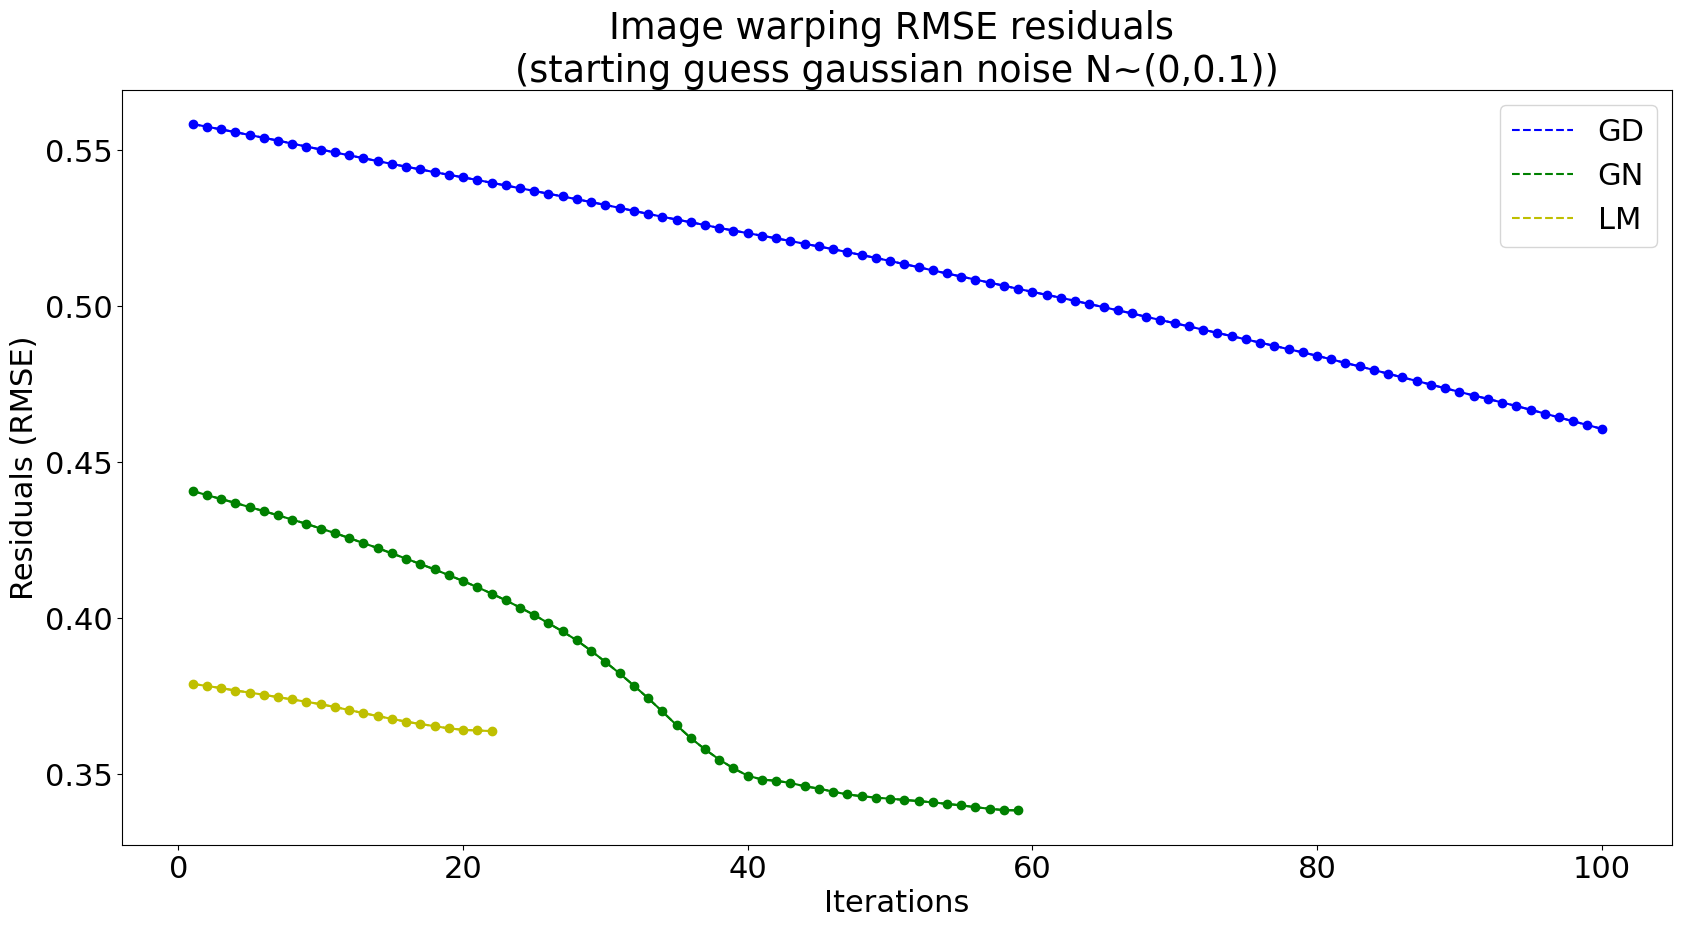

In [47]:
import matplotlib.pyplot as plt  
y1=data[7]
x1=np.arange(1,len(y1)+1,1)
y2=data2[7]
x2=np.arange(1,len(y2)+1,1)
y3=data3[7]
x3=np.arange(1,len(y3)+1,1)

colors = {0:'b',1:'g',2:'r',3:'darkkhaki',4:'m',5:'y',6:'cornflowerblue',7:'seagreen', 8:'bisque', 9:'slategrey'}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
plt.rc('font', **font)
plt.figure(figsize=(20,10), dpi=100)

ls=plt.plot(x1,y1,color=colors[0], linestyle='dashed',label='GD')
ls=plt.plot(x2,y2,color=colors[1], linestyle='dashed',label='GN')
ls=plt.plot(x3,y3,color=colors[5], linestyle='dashed',label='LM')
plt.plot(x1,y1,'bo-',x2,y2,'go-',x3,y3,'yo-')
plt.title('Image warping RMSE residuals \n(starting guess gaussian noise N~(0,0.1))')
plt.xlabel('Iterations')
plt.ylabel('Residuals (RMSE)')
plt.legend()
# plt.show()
plt.savefig('test.png')

## ** prepare dataset

In [53]:
mylist = np.random.randint(0,798,(10,))
import os 
import shutil
from scipy.spatial.transform import Rotation as R
rgbpath = '/home/runqiu/lectures/dc1/numeric-analysis/NAreport3_RunqiuBao_37207318/rgbd_dataset_freiburg1_xyz/rgb/'
depthpath = '/home/runqiu/lectures/dc1/numeric-analysis/NAreport3_RunqiuBao_37207318/rgbd_dataset_freiburg1_xyz/depth/'
rgbfilelist = os.listdir(rgbpath)
rgbfilelist.sort()
depthfilelist = os.listdir(depthpath)
depthfilelist.sort()
rgbtarget = '/home/runqiu/lectures/dc1/numeric-analysis/NAreport3_RunqiuBao_37207318/rgbd_dataset_freiburg1_xyz/close/rgb/'
depthtarget = '/home/runqiu/lectures/dc1/numeric-analysis/NAreport3_RunqiuBao_37207318/rgbd_dataset_freiburg1_xyz/close/depth/'
gtfile = '/home/runqiu/lectures/dc1/numeric-analysis/NAreport3_RunqiuBao_37207318/rgbd_dataset_freiburg1_xyz/groundtruth.txt'
gtdict = {}
for i,imgindex in enumerate(mylist):
    shutil.copy(os.path.join(rgbpath, rgbfilelist[imgindex]), os.path.join(rgbtarget, 'IRef'+str(i)+'.png'))
    shutil.copy(os.path.join(rgbpath, rgbfilelist[imgindex+1]), os.path.join(rgbtarget, 'I'+str(i)+'.png'))
    shutil.copy(os.path.join(depthpath, depthfilelist[imgindex]), os.path.join(depthtarget, 'DRef'+str(i)+'.png'))
    shutil.copy(os.path.join(depthpath, depthfilelist[imgindex+1]), os.path.join(depthtarget, 'D'+str(i)+'.png'))
    with open(gtfile) as f:
        lines = f.readlines()
        c1 = lines[imgindex+3].split('\n')[0]
        c2 = lines[imgindex+4].split('\n')[0]
        c1 = c1.split(' ')
        c2 = c2.split(' ')
        Twc1 = np.zeros((4,4))
        Twc2 = np.zeros((4,4))
        Twc1[3,3]=1
        Twc1[0,3]=float(c1[1])
        Twc1[1,3]=float(c1[2])
        Twc1[2,3]=float(c1[3])
        Twc2[3,3]=1
        Twc2[0,3]=float(c2[1])
        Twc2[1,3]=float(c2[2])
        Twc2[2,3]=float(c2[3])
        r1 = R.from_quat([float(c1[4]), float(c1[5]), float(c1[6]), float(c1[7])])
        r2 = R.from_quat([float(c2[4]), float(c2[5]), float(c2[6]), float(c2[7])])
        Twc1[0:3,0:3] = r1.as_matrix()
        Twc2[0:3,0:3] = r2.as_matrix()
        Tc1c2 = np.matmul(np.linalg.inv(Twc1),Twc2)
        gtpose = se3Log(Tc1c2)
        gtdict[i] = gtpose
np.save("/home/runqiu/lectures/dc1/numeric-analysis/NAreport3_RunqiuBao_37207318/rgbd_dataset_freiburg1_xyz/close/gt.npy", gtdict, allow_pickle=True)
np.save('/home/runqiu/lectures/dc1/numeric-analysis/NAreport3_RunqiuBao_37207318/rgbd_dataset_freiburg1_xyz/close/samplelist.npy', mylist, allow_pickle=True)

IndexError: list index out of range

In [ ]:
import os 
import shutil
from scipy.spatial.transform import Rotation as R
indexlist = np.array([559, 552, 95, 651, 368, 589, 726, 413, 429, 778])
gtfile = '/home/runqiu/lectures/dc1/numeric-analysis/NAreport3_RunqiuBao_37207318/rgbd_dataset_freiburg1_xyz/groundtruth.txt'
gtdict = {}
for i,imgindex in enumerate(indexlist):
    with open(gtfile) as f:
        lines = f.readlines()
        c1 = lines[imgindex+3].split('\n')[0]
        c2 = lines[imgindex+8].split('\n')[0]
        c1 = c1.split(' ')
        c2 = c2.split(' ')
        Twc1 = np.zeros((4,4))
        Twc2 = np.zeros((4,4))
        Twc1[3,3]=1
        Twc1[0,3]=float(c1[1])
        Twc1[1,3]=float(c1[2])
        Twc1[2,3]=float(c1[3])
        Twc2[3,3]=1
        Twc2[0,3]=float(c2[1])
        Twc2[1,3]=float(c2[2])
        Twc2[2,3]=float(c2[3])
        r1 = R.from_quat([float(c1[4]), float(c1[5]), float(c1[6]), float(c1[7])])
        r2 = R.from_quat([float(c2[4]), float(c2[5]), float(c2[6]), float(c2[7])])
        Twc1[0:3,0:3] = r1.as_matrix()
        Twc2[0:3,0:3] = r2.as_matrix()
        Tc1c2 = np.matmul(np.linalg.inv(Twc1),Twc2)
        Tc2c1 = np.linalg.inv(Tc1c2)
        gtpose = se3Log(Tc2c1)
        gtdict[i] = gtpose
np.save("/home/runqiu/lectures/dc1/numeric-analysis/NAreport3_RunqiuBao_37207318/rgbd_dataset_freiburg1_xyz/middle/gt.npy", gtdict, allow_pickle=True)